In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5208345136992649057, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16034600339893667201
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from collections import Counter
import itertools
import shutil
import random
import glob
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline

In [5]:
import cv2

In [6]:
def check_image(image):  
    '''
      Input an image,
      It checks whether it is a RGB type or not. If not, it converts the image to RGB and returns that.
      
    '''

    img = cv2.imread(image)

    if len(img.shape)==2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif len(img.shape)==3 and img.shape[2]==1:
        img = cv2.cvtColor(img[:, :, 0], cv2.COLOR_GRAY2RGB)
    elif len(img.shape)==3 and img.shape[2]==2:
        img = cv2.cvtColor(img[:, :, 0], cv2.COLOR_GRAY2RGB)
    
    return img

In [ ]:
'''def denoise_image(img_arr):
    

       # Input a read image,
       # It denoises the image and returns the filtered one.
       
    
    ret = cv2.fastNlMeansDenoisingColored(img_arr, None, 10, 10, 7, 21)
    
    return ret '''

# denoising images using fastNlMeans method might lead to loss of important features of the image. So better, avoid that.

In [7]:
''' Count of images for eight different age groups are:
                                                            00: 920
                                                            01: 1063
                                                            02: 2621
                                                            03: 2664
                                                            04: 1556
                                                            05: 919
                                                            06: 550
                                                            07: 375 
So, randomely select 915 images from each of the classes 00, 01, 02, 03, 04, 05. And do the data augmentation for classes 06  
and 07 to make each of them have 915 images too. Total we will have 915*8 images in the training set.'''

In [7]:
def data_sampling(num):
    
    # randomely collects 915 images from each of the classes/folders: 00, 01, 02, 03, 04, and 05. And put those collected 
    # images to their corresponding newly created folders/classes: 0, 1, 2, 3, 4, and 5 respectively.
    
    path = r'C:\Users\harsh raj\OneDrive\Desktop\third_proj\train'
    str1 = '0' + str(num) 
    str2 = str(num)
    path = path + '/' + str1
    
    os.chdir(path)
    if os.path.isdir(str2) is False:
        os.makedirs(str2)
    
        for c in random.sample(glob.glob('000*'), 915):
            shutil.move(c, str2)

In [8]:
for i in range(6):
    data_sampling(i)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

def data_augmentation(numb): 
    
    datagen = ImageDataGenerator(
                                rotation_range = 40,
                                width_shift_range = 0.2,
                                height_shift_range = 0.2,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                fill_mode = 'nearest')

    # Did data augmentation of 'valu' number of images randomely selected inside the folder/class '06' & '07' each, such that
    # each image produces 5 augmented images. => Total of valu*5 images produced for each of the '06' and '07 according to it's
    # 'valu'. The produced images are saved in the same folder '06' or '07' correspondingly. 
    # So, in total, there are 550+valu*5 = 915 images in the folder '06' and 375+valu*5 = 915 images in the folder '07'. 
    # And thus, we have 915 images for each class now.
    
    stree = '0' + str(numb)
    pathh = r'C:\Users\harsh raj\OneDrive\Desktop\third_proj\train' + '/' + stree
    
    if numb == 6:
        valu = 73
    else:
        valu = 108
    
    os.chdir(pathh)     # in the pathh directory.
    for ci in random.sample(glob.glob('000*'), valu):

        im = load_img(ci)
        imgg = img_to_array(im)
        imgg = imgg.reshape((1,) + imgg.shape)

        j = 0
        for batch in datagen.flow(imgg, batch_size = 1,
                                        save_to_dir = pathh, save_format = 'jpg'):
            j += 1
            if j>4:
                break    

In [10]:
data_augmentation(6)   # data augmentation in the folder '06'
data_augmentation(7)   # data augmentation in the folder '07'

In [11]:
# Before further preprocessing, we copied the folders '0', '1', '2', '3', '4', '5', '06', and '07' from the 'train' folder and 
# pasted them as '0', '1', '2', '3', '4', '5', '6', and '7' in a new folder named 'train_final'.

In [12]:
from google.colab import drive
drive.mount('/content/Pdrive')

Mounted at /content/Pdrive


In [13]:
train_path = '/content/Pdrive/MyDrive/Colab Notebooks/train_final'
target_folder = '/content/Pdrive/MyDrive/Colab Notebooks/train_preprocessed'

In [14]:
import glob

# This cell will do the face detection for each of the images present in the training folder (train_path)
# Each image will then be cropped and the faces extracted will be saved to a new directory with the same label.

count = 0

face_detection = cv2.CascadeClassifier('/content/Pdrive/MyDrive/Colab Notebooks/face_det_haarcascade.xml')

for a_var in range(8):
  folder_path = train_path + '/' + str(a_var)

  for filename in glob.iglob(folder_path + '**/*.jpg', recursive = True):
    read_image = cv2.imread(filename)
    gray = cv2.cvtColor(read_image, cv2.COLOR_BGR2GRAY)
    faces = face_detection.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5)

    for (x, y, w, h) in faces:
      face_img = read_image[y:y+h, x:x+w]
      cv2.imwrite(target_folder + '/' + str(a_var) + '/' + 'saved' + str(count) + '.jpg', face_img)
      count+=1

In [16]:
print(count)

6069


In [17]:
# collect and preprocess all the 7305 images of training set.
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
     .flow_from_directory(directory = target_folder, target_size = (224, 224),   # collect all the input images and preprocess them all at once.
                         classes = ['0', '1', '2', '3', '4', '5', '6', '7'], batch_size = 6069)   

Found 6069 images belonging to 8 classes.


In [18]:
# verify whether we got the required number of images from the directory or not.
assert train_batches.n == 6069
assert train_batches.num_classes == 8

In [19]:
imgs, labels = next(train_batches)  # collected the complete training set as X_train = imgs & y_train = labels.

In [20]:
print(imgs.shape)
print(labels.shape)

(6069, 224, 224, 3)
(6069, 8)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Conv2D, MaxPool2D, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [22]:
def create_model():
  
  vgg16_model = tf.keras.applications.vgg16.VGG16()

  model = Sequential()
  for layer in vgg16_model.layers[:-1]:
      model.add(layer)

  for layer in model.layers:
      layer.trainable = False

  model.add(Dense(units = 8, activation = 'softmax'))

  return model

In [23]:
model = create_model()
model.compile(
      optimizer = Adam(learning_rate = 0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy'])

model.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_______________________________________________________

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

model.fit(
    x = imgs, y = labels, batch_size = 128, epochs = 60, verbose = 2
)

Epoch 1/60
48/48 - 28s - loss: 0.9006 - accuracy: 0.7013
Epoch 2/60
48/48 - 29s - loss: 0.8651 - accuracy: 0.7182
Epoch 3/60
48/48 - 28s - loss: 0.8488 - accuracy: 0.7090
Epoch 4/60
48/48 - 28s - loss: 0.8119 - accuracy: 0.7332
Epoch 5/60
48/48 - 28s - loss: 0.7871 - accuracy: 0.7476
Epoch 6/60
48/48 - 28s - loss: 0.7578 - accuracy: 0.7639
Epoch 7/60
48/48 - 28s - loss: 0.7397 - accuracy: 0.7657
Epoch 8/60
48/48 - 28s - loss: 0.7375 - accuracy: 0.7612
Epoch 9/60
48/48 - 28s - loss: 0.7190 - accuracy: 0.7637
Epoch 10/60
48/48 - 28s - loss: 0.6802 - accuracy: 0.7985
Epoch 11/60
48/48 - 28s - loss: 0.6601 - accuracy: 0.8085
Epoch 12/60
48/48 - 28s - loss: 0.6537 - accuracy: 0.8087
Epoch 13/60
48/48 - 28s - loss: 0.6374 - accuracy: 0.8206
Epoch 14/60
48/48 - 28s - loss: 0.6178 - accuracy: 0.8286
Epoch 15/60
48/48 - 28s - loss: 0.6081 - accuracy: 0.8248
Epoch 16/60
48/48 - 28s - loss: 0.5943 - accuracy: 0.8344
Epoch 17/60
48/48 - 28s - loss: 0.5824 - accuracy: 0.8440
Epoch 18/60
48/48 - 28s

In [29]:
test_path = '/content/Pdrive/MyDrive/Colab Notebooks/test'   # the path to access all the test images

In [31]:
import glob
from tensorflow.keras.applications.vgg16 import preprocess_input

df = pd.DataFrame({'Image Name': [], 'Labels': []}, columns = ['Image Name', 'Labels'])

# preprocess all the test images now. (similarly how train images were done)

for filename in glob.iglob(test_path + '**/*.jpg', recursive=True):
  imag = cv2.imread(filename)
  gray_imag = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)
  face_det = face_detection.detectMultiScale(gray_imag, scaleFactor = 1.1, minNeighbors = 5)

  for (x, y, w, h) in face_det:
    face_imag = imag[y:y+h, x:x+w]
    face_imag = cv2.resize(face_imag, (224, 224))
    face_imag = face_imag.reshape((1,) + face_imag.shape)
    face_imag = preprocess_input(face_imag)
    pred_val = model.predict(face_imag)
    got_val = np.argmax(pred_val)
    shit = filename
    shiit = shit.split('/')[6]
    df.loc[len(df.index)] = [shiit, got_val]


In [32]:
df['Labels'] = df['Labels'].astype(int)

In [33]:
df.to_csv('/content/Pdrive/MyDrive/Colab Notebooks/Final-Submission.csv', index = False)  
# This dataframe contains all the test images with their labels as predicted by the model.

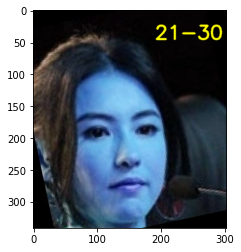

In [45]:
# Let's take a test by choosing a random image from the final dataframe (df) and see it's label predicted. (do human check to verify).

test1 = cv2.imread(test_path + '/' + df['Image Name'][3])
font = cv2.FONT_HERSHEY_SIMPLEX

temp = df['Labels'][3]
if(temp==0):
  text = '1-10'
elif(temp==1):
  text = '11-20'
elif(temp==2):
  text = '21-30'
elif(temp==3):
  text = '31-40'
elif(temp==4):
  text = '41-50'
elif(temp==5):
  text = '51-60'
elif(temp==6):
  text = '61-70'
else:
  text = '71-80'

cv2.putText(test1, text, (190,45), font, 1, (255,255), 2, cv2.LINE_AA)
plt.imshow(test1)